In [1]:
import os

import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import zoom

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import scipy.stats
from scipy.stats import norm,t

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [3]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(270, 10)


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [8]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [9]:
train_data.shape,test_data.shape

((210,), (60,))

In [10]:
seasonal = pd.read_csv('계절성예측.csv')
print(seasonal.shape)

(60, 1)


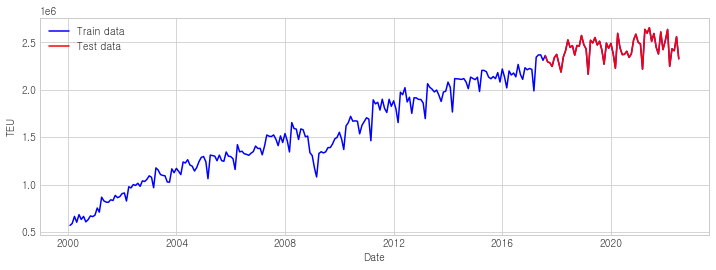

In [11]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [12]:
pd.set_option('display.max_columns', None)
trend = pd.read_csv('TEU분해.csv')
trend['Date'] = pd.to_datetime(trend['Date'])
trend = trend.set_index('Date')
print(trend.shape)
trend.head()

(60, 1)


,TEU_Trend
Date,
2017-07-31,2291408.583
2017-08-31,2302073.625
2017-09-30,2310450.375
2017-10-31,2312407.958
2017-11-30,2320814.042


### 2. 다변량 LSTM

In [13]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [14]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [15]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [16]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [17]:
raw_df = data

In [18]:
split = -78
train = raw_df[0:split] 
test = raw_df[split:] 

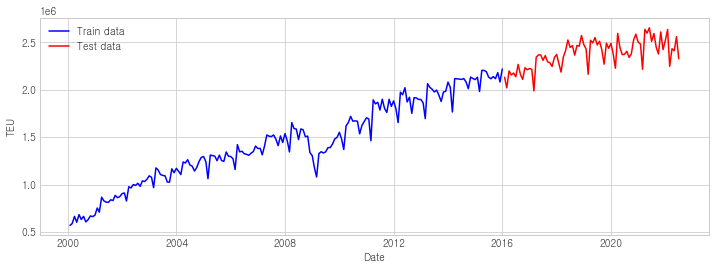

In [19]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend()

In [20]:
len(train),len(test)

(192, 78)

In [21]:
data.columns

Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU','BDI', 'ln(HRCI)', 'ln(SCFI)','수출물가지수','환율','전산업생산지수','경상수지','ln(다우존스지수)','화물수송총괄']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [23]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [24]:
window_size = 18 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 36   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [25]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [26]:
X_train.shape,Y_train.shape

((139, 18, 10), (139, 36, 1))

### 2. X_test,Y_test 배열

In [27]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [28]:
X_test.shape,Y_test.shape

((25, 18, 10), (25, 36, 1))

In [29]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [30]:
from tcn import TCN, tcn_full_summary

In [31]:
model = Sequential() # Encoder & Decoder

## Encoder state
model.add(TCN(nb_filters=48,kernel_size=2,activation='tanh',padding='causal',input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False))
model.add(MCDropout(0.8))
model.add(Dense(1))
model.add(RepeatVector(36)) # 출력 개수만큼 반복 

## Decoder State
model.add(TCN(nb_filters=48, activation='tanh', return_sequences=True))  # Decoder State 
model.add(MCDropout(0.8))
model.add(TimeDistributed(Dense(8,activation='relu'))) 
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, Y_train, epochs= 200, batch_size=10, validation_split=0.02,callbacks=[early_stop])

Epoch 1/200
14/14 [==============================] - 8s 277ms/step - loss: 4.4568 - mae: 1.4573 - val_loss: 0.4735 - val_mae: 0.5932
Epoch 2/200
14/14 [==============================] - 0s 33ms/step - loss: 0.3723 - mae: 0.4761 - val_loss: 0.4204 - val_mae: 0.5633
Epoch 3/200
14/14 [==============================] - 0s 25ms/step - loss: 0.2086 - mae: 0.3579 - val_loss: 0.3023 - val_mae: 0.4878
Epoch 4/200
14/14 [==============================] - 0s 23ms/step - loss: 0.1744 - mae: 0.3327 - val_loss: 0.2843 - val_mae: 0.4623
Epoch 5/200
14/14 [==============================] - 0s 23ms/step - loss: 0.1327 - mae: 0.2911 - val_loss: 0.2918 - val_mae: 0.4873
Epoch 6/200
14/14 [==============================] - 0s 27ms/step - loss: 0.1170 - mae: 0.2710 - val_loss: 0.2578 - val_mae: 0.4628
Epoch 7/200
14/14 [==============================] - 0s 23ms/step - loss: 0.1086 - mae: 0.2612 - val_loss: 0.2190 - val_mae: 0.4050
Epoch 8/200
14/14 [==============================] - 0s 22ms/step - loss: 0

In [32]:
rcParams['figure.figsize'] = 12, 4

<AxesSubplot:>

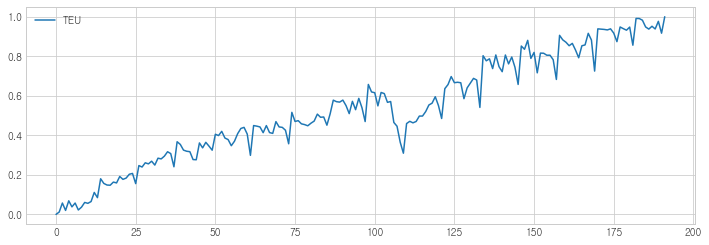

In [33]:
label_train.plot()

<AxesSubplot:>

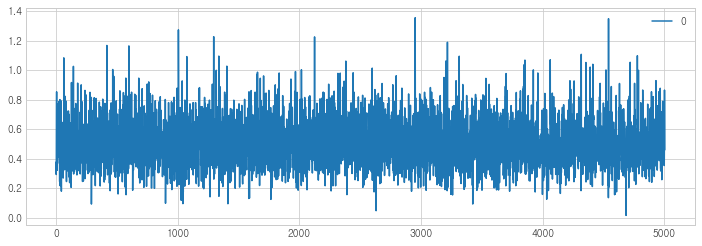

In [34]:
pd.DataFrame(model.predict(X_train).reshape(-1,1)).plot()

### 1. 2017.07 ~ 2020.06

In [35]:
X_test_1 = np.array(feature_test.head(18)).reshape((1, 18, 10)) 

In [36]:
model_MC=  model
prediction = [model_MC.predict(X_test_1) for sample in range(30)]

In [37]:
dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

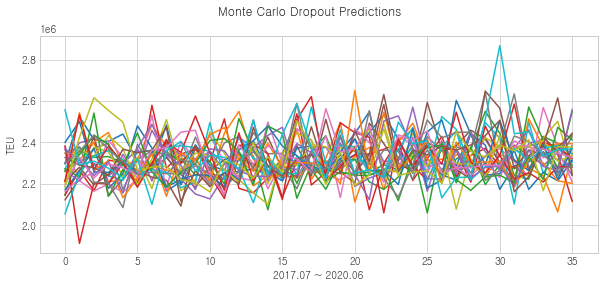

In [38]:
rcParams['figure.figsize'] = 10, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2017.07 ~ 2020.06')
plt.ylabel('TEU')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [39]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [40]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [41]:
np.mean(df.std()/df.mean())

0.044396817684173584

In [42]:
rmse = math.sqrt(mean_squared_error(trend[0:36].reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:36].reset_index()['TEU_Trend']- df.transpose().mean())/ trend[0:36].reset_index()['TEU_Trend'])*100) )

RMSE: 93809.59154567393
MAPE: 3.5172573799608764


In [43]:
rmse = math.sqrt(mean_squared_error(trend[0:36].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:36].reset_index()['TEU_Trend']- df.transpose().median())/ trend[0:36].reset_index()['TEU_Trend'])*100) )

RMSE: 104601.58637246072
MAPE: 3.8559141268624435


In [40]:
df2 = pd.read_csv('TEU분해.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.head(36)

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-31,2295863.0,2260649.5,2145466.25,2145833.0,2301789.75,2122425.5,2381006.0,2364515.75,2272271.0,2273075.25,2171830.5,2346710.0,2272161.5,2383511.75,2263857.0,2214187.25,2162272.5,2349293.25,2205765.25,2054965.875,2399697.5,2213052.0,2259303.75,2211789.5,2368603.0,2327748.0,2195155.25,2297930.25,2183643.75,2557978.25


In [41]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:246]
data.head(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.91343,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88


Mean RMSE: 132791.30069054526
Mean MAPE: 4.841881214917603


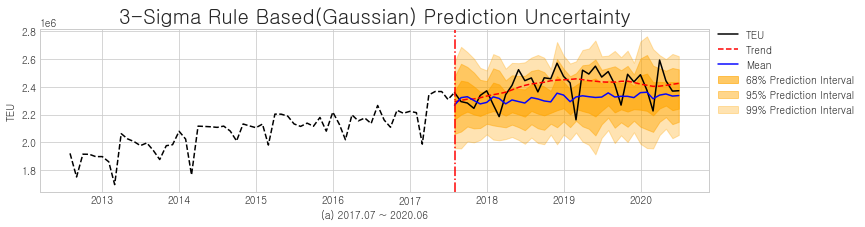

In [42]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2020.06')
plt.ylabel('TEU')
plt.title('3-Sigma Rule Based(Gaussian) Prediction Uncertainty',fontsize=20)
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:246], 'black', label='TEU')
plt.plot(trend.head(36),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='orange', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='orange', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='orange',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df.transpose().mean())/ test_data.head(36).reset_index()['TEU'])*100) )

In [43]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(36).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.9166666666666666

In [44]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(36).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.6111111111111112

In [45]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 202332.31
Quantile 70% Interval Sharpness 192488.09166666647


Median RMSE: 144622.90466936835
Median MAPE: 5.206591370127224


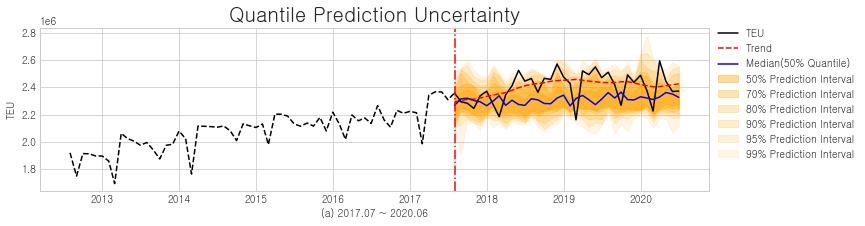

In [46]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2020.06')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=20)
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:246], 'black', label='TEU')
plt.plot(trend.head(36),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='orange', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='orange', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='orange', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='orange', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='orange', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='orange', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df.transpose().median()))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df.transpose().median())/ test_data.head(36).reset_index()['TEU'])*100) )

In [47]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(36).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.8611111111111112

In [48]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(36).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.5555555555555556

In [49]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(36).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.9444444444444444

In [50]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 404664.62
Quantile 95% Interval Sharpness 356717.5678819444
Min Max Interval Sharpness 438141.84


In [51]:
import CRPS.CRPS as pscore

In [52]:
crps = []

for i in range(0,36):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.head(36).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

55840.643749999996
24867.056527777782
30535.320555555558
33898.38611111111
36699.26041666667
55270.77527777778
27685.12027777778
79828.32111111113
38988.00652777778
67941.98361111112
178502.81
113901.61722222224
97539.96305555556
36348.854722222226
114284.8251388889
125504.71722222221
150397.7247222222
101368.66916666666
104486.66055555556
119564.89611111111
133726.4783333333
107537.68361111113
160646.2358333333
95765.64444444445
107758.30111111111
53598.57902777777
43114.57194444444
110819.37930555557
71988.84416666668
89989.50611111113
33437.28
46575.98861111111
199663.45194444447
58175.40638888889
22942.070416666662
26944.319444444445


In [53]:
a = np.array([55840.643749999996,
24867.056527777782,
30535.320555555558,
33898.38611111111,
36699.26041666667,
55270.77527777778,
27685.12027777778,
79828.32111111113,
38988.00652777778,
67941.98361111112,
178502.81,
113901.61722222224,
97539.96305555556,
36348.854722222226,
114284.8251388889,
125504.71722222221,
150397.7247222222,
101368.66916666666,
104486.66055555556,
119564.89611111111,
133726.4783333333,
107537.68361111113,
160646.2358333333,
95765.64444444445,
107758.30111111111,
53598.57902777777,
43114.57194444444,
110819.37930555557,
71988.84416666668,
89989.50611111113,
33437.28,
46575.98861111111,
199663.45194444447,
58175.40638888889,
22942.070416666662,
26944.319444444445])

In [55]:
np.mean(a)

82114.98202160494

In [43]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2318949.0

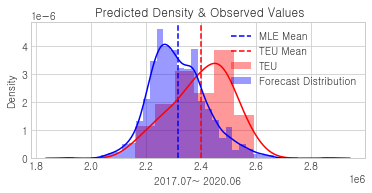

In [44]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.head(36).mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.head(36).reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2017.07~ 2020.06')
plt.legend()

In [47]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.head(36).reset_index()['TEU'].mean(), scale=test_data.head(36).reset_index()['TEU'].std() ) )
LL

14317.298606658835

In [48]:
LL = -np.sum( stats.norm.logpdf(test_data.head(36).reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

947.7664088099887

In [45]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [46]:
for i in range(0,30):
    print(KL(df[i],test_data.head(36).reset_index()['TEU']))

2533344.777184798
3435141.852870531
3112813.8485366614
3274258.2714155084
3446530.9037213405
2729750.491133349
3204362.2116066865
2198927.354735762
2931444.3010500255
2734015.8524079365
2953681.0662977924
2287994.138533903
3400060.323564162
3044976.5615906417
2134923.320438297
2583436.9188451385
3300062.2978111696
2850893.416254881
2365908.51157899
2896387.7564046234
2621535.5463167145
2994466.7262230325
3383333.8314535776
2674555.778966789
3023440.0838615038
2352442.7452274393
2181048.498760373
2351367.9312873115
2563799.582049358
1347603.9934267679


In [49]:
 a = np.array([2533344.777184798,
3435141.852870531,
3112813.8485366614,
3274258.2714155084,
3446530.9037213405,
2729750.491133349,
3204362.2116066865,
2198927.354735762,
2931444.3010500255,
2734015.8524079365,
2953681.0662977924,
2287994.138533903,
3400060.323564162,
3044976.5615906417,
2134923.320438297,
2583436.9188451385,
3300062.2978111696,
2850893.416254881,
2365908.51157899,
2896387.7564046234,
2621535.5463167145,
2994466.7262230325,
3383333.8314535776,
2674555.778966789,
3023440.0838615038,
2352442.7452274393,
2181048.498760373,
2351367.9312873115,
2563799.582049358,
1347603.9934267679])

In [50]:
np.mean(a)

2763750.296451836

In [44]:
df.to_csv('TCN.csv')

### 2. 2019.07 ~ 2022.06

In [45]:
X_test_2 = np.array(feature_test[24:42]).reshape((1, 18, 10)) 

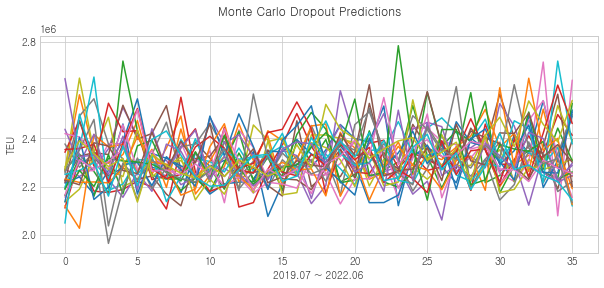

In [46]:
model_MC=  model
prediction = [model_MC.predict(X_test_2) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 10, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2019.07 ~ 2022.06')
plt.ylabel('TEU')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [47]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [48]:
np.mean(df.std()/df.mean())

0.0456075556576252

In [49]:
rmse = math.sqrt(mean_squared_error(trend.tail(36).reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.tail(36).reset_index()['TEU_Trend']- df.transpose().mean())/ trend.tail(36).reset_index()['TEU_Trend'])*100) )

RMSE: 153388.96463443365
MAPE: 6.079627145397614


In [50]:
df.to_csv('TCN.csv')

In [54]:
rmse = math.sqrt(mean_squared_error(trend.tail(36).reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.tail(36).reset_index()['TEU_Trend']- df.transpose().median())/ trend.tail(36).reset_index()['TEU_Trend'])*100) )

RMSE: 166080.11556219982
MAPE: 6.580128446678175


In [55]:
df2 = pd.read_csv('TEU분해.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.tail(36)

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-31,2192206.0,2266457.75,2270811.0,2111071.75,2272170.75,2225916.25,2156372.5,2255618.0,2267185.0,2198328.0,2214708.75,2120681.75,2188631.75,2342468.75,2438071.75,2217591.0,2419876.5,2377052.75,2137014.25,2250421.0,2136367.5,2231531.25,2163594.25,2353738.75,2648497.25,2226525.0,2164735.25,2262967.0,2281648.0,2048142.125


In [56]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
#data = data.iloc[:246]
data.head(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.91343,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88


Mean RMSE: 180851.9380842081
Mean MAPE: 6.202228560541205


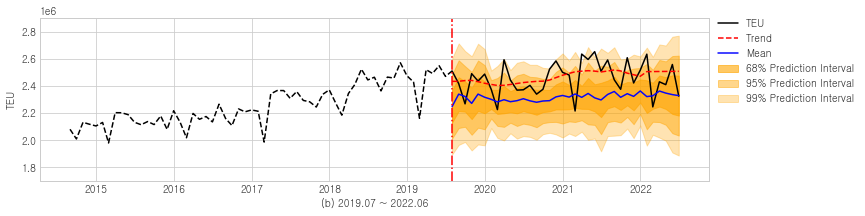

In [59]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2019.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[175:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:], 'black', label='TEU')
plt.plot(trend.tail(36),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='orange', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='orange', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='orange',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df.transpose().mean())/ test_data.tail(36).reset_index()['TEU'])*100) )

In [74]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(36).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.6944444444444444


In [75]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(36).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

추세 변동에 대한 포함확률: 0.08333333333333333


In [76]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 205241.56
Quantile 70% Interval Sharpness 192364.60763888893


Median RMSE: 192888.19539449117
Median MAPE: 6.645225238891836


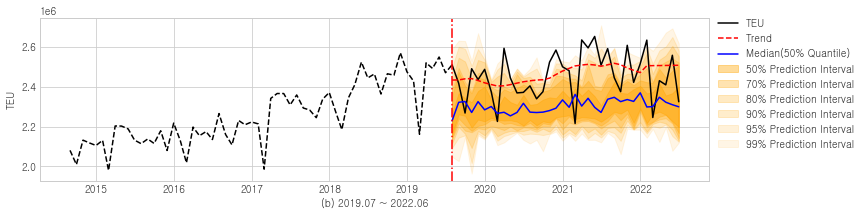

In [77]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2019.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
#plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[175:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:], 'black', label='TEU')
plt.plot(trend.tail(36),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue')
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='orange', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='orange', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='orange', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='orange', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='orange', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='orange', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df.transpose().median()))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df.transpose().median())/ test_data.tail(36).reset_index()['TEU'])*100) )

In [78]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(36).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.6944444444444444

In [79]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(36).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.08333333333333333

In [80]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 410483.12
Quantile 95% Interval Sharpness 362705.9534722221
Min Max Interval Sharpness 446355.25


In [81]:
crps = []

for i in range(0,36):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.tail(36).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

210676.48708333334
56364.946388888886
32085.498055555556
161411.4884722222
65004.11555555556
114666.04166666667
47557.32055555557
30831.26638888889
239952.7186111111
116618.31888888888
58974.535833333335
38929.40083333333
81551.32750000001
40886.23638888889
53081.365694444445
187472.35416666666
215181.76416666666
115564.07944444445
117954.38305555555
82368.7838888889
273027.1461111111
189867.88055555554
286822.7366666667
170735.3711111111
197046.4738888889
52798.33666666666
32448.426805555548
220148.88527777776
59550.89083333333
109250.86444444445
247393.08472222224
43067.98972222223
48269.595
54568.16916666667
163565.33944444446
40999.7863888889


In [82]:
a = np.array([210676.48708333334,
56364.946388888886,
32085.498055555556,
161411.4884722222,
65004.11555555556,
114666.04166666667,
47557.32055555557,
30831.26638888889,
239952.7186111111,
116618.31888888888,
58974.535833333335,
38929.40083333333,
81551.32750000001,
40886.23638888889,
53081.365694444445,
187472.35416666666,
215181.76416666666,
115564.07944444445,
117954.38305555555,
82368.7838888889,
273027.1461111111,
189867.88055555554,
286822.7366666667,
170735.3711111111,
197046.4738888889,
52798.33666666666,
32448.426805555548,
220148.88527777776,
59550.89083333333,
109250.86444444445,
247393.08472222224,
43067.98972222223,
48269.595,
54568.16916666667,
163565.33944444446,
40999.7863888889])

In [83]:
np.mean(a)

118241.48359567899

In [57]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2316225.2

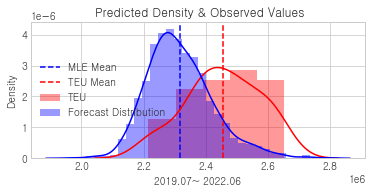

In [58]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.tail(36).mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.tail(36).reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2019.07~ 2022.06')
plt.legend()

In [59]:
LL = -np.sum( stats.norm.logpdf(df, loc=test_data.tail(36).reset_index()['TEU'].mean(), scale=test_data.tail(36).reset_index()['TEU'].std() ) )
LL

14771.82413895905

In [60]:
LL = -np.sum( stats.norm.logpdf(test_data.tail(36).reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

1203.3962074335316

In [61]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [62]:
for i in range(0,30):
    print(KL(df[i],test_data.tail(36).reset_index()['TEU']))

4321049.923149799
4451424.025007872
4658223.994295164
5188001.198154713
5778186.3459155075
3777725.4162700856
4523403.407475433
4611263.732593693
4892665.761619978
4063111.1740297764
5424001.001594213
4262129.732707395
4544672.998003962
4026918.4275820386
3967310.892174999
4624441.712450812
5415942.366790748
4860198.258411332
5348564.525525396
4482585.013258641
4349613.691504065
5408642.680058194
4619178.666331697
4280850.935513517
4291345.611887278
4486199.479284994
4954149.820587235
4579889.308874644
3630027.77833697
5428511.247303976


In [65]:
a = np.array([4321049.923149799,
4451424.025007872,
4658223.994295164,
5188001.198154713,
5778186.3459155075,
3777725.4162700856,
4523403.407475433,
4611263.732593693,
4892665.761619978,
4063111.1740297764,
5424001.001594213,
4262129.732707395,
4544672.998003962,
4026918.4275820386,
3967310.892174999,
4624441.712450812,
5415942.366790748,
4860198.258411332,
5348564.525525396,
4482585.013258641,
4349613.691504065,
5408642.680058194,
4619178.666331697,
4280850.935513517,
4291345.611887278,
4486199.479284994,
4954149.820587235,
4579889.308874644,
3630027.77833697,
5428511.247303976])

In [66]:
np.mean(a)

4641674.304223138